In [1]:
import numpy as np
import pandas as pd

In [2]:
train_dir='/notebooks/Signature_Verification_dataset/sign_data/sign_data/train/'
test_dir='/notebooks/Signature_Verification_dataset/sign_data/sign_data/test/'

In [3]:
import os 
os.chdir('/notebooks/Signature_Verification_dataset/sign_data/sign_data')

In [4]:
df_train=pd.read_csv('/notebooks/Signature_Verification_dataset/sign_data/sign_data/train_data.csv')
df_train.head()

,068/09_068.png,068_forg/03_0113068.PNG,1
0,068/09_068.png,068_forg/01_0124068.PNG,1
1,068/09_068.png,068_forg/02_0124068.PNG,1
2,068/09_068.png,068_forg/01_0113068.PNG,1
3,068/09_068.png,068_forg/04_0124068.PNG,1
4,068/09_068.png,068_forg/04_0113068.PNG,1


In [5]:
df_train.iat[1,0]

'068/09_068.png'

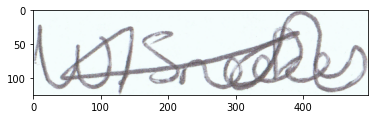

In [6]:
import matplotlib.pyplot as plt
img=plt.imread(train_dir+df_train.iat[1,0])
plt.imshow(img)

In [7]:
import cv2
train_images1=[]
train_images2=[]
train_labels=[]
for i in range(len(df_train)):
    img1=cv2.imread(train_dir+df_train.iat[i,0])
    img1=cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    img1=cv2.resize(img1,(48,48))
    train_images1.append(img1)
    
    img2=cv2.imread(train_dir+df_train.iat[i,1])
    img2=cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    img2=cv2.resize(img2,(48,48))
    train_images2.append(img2)
    
    train_labels.append(df_train.iat[i,2])
train_images1=np.array(train_images1)/255.0
train_images2=np.array(train_images2)/255.0
train_images1=np.expand_dims(train_images1,-1)
train_images2=np.expand_dims(train_images2,-1)
train_labels=np.array(train_labels)

In [8]:
df_test=pd.read_csv('/notebooks/Signature_Verification_dataset/sign_data/sign_data/test_data.csv')
df_test.head()

,068/09_068.png,068_forg/03_0113068.PNG,1
0,068/09_068.png,068_forg/01_0124068.PNG,1
1,068/09_068.png,068_forg/02_0124068.PNG,1
2,068/09_068.png,068_forg/01_0113068.PNG,1
3,068/09_068.png,068_forg/04_0124068.PNG,1
4,068/09_068.png,068_forg/04_0113068.PNG,1


In [9]:
df_test.iat[1,0]

'068/09_068.png'

In [10]:
test_images1=[]
test_images2=[]
for j in range(len(df_test)):
    img1=cv2.imread(test_dir+df_test.iat[j,0])
    img1=cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    img1=cv2.resize(img1,(48,48))
    test_images1.append(img1)
    
    img2=cv2.imread(test_dir+df_test.iat[j,1])
    img2=cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    img2=cv2.resize(img2,(48,48))
    test_images2.append(img2)

In [11]:
test_images1=np.array(test_images1)/255.0
test_images2=np.array(test_images2)/255.0
test_images1=np.expand_dims(test_images1,-1)
test_images2=np.expand_dims(test_images2,-1)
test_labels=np.array(df_test['1'])

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D,Dense,Dropout,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Lambda,BatchNormalization
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [13]:
def euclidean_distance(vectors):
    (featsA,featsB)=vectors
    
    sumSquared=K.sum(K.square(featsA-featsB),axis=1,keepdims=True)
    return K.sqrt(K.maximum(sumSquared,K.epsilon()))

In [14]:
def contrastive_loss(y,preds,margin=1):
    y=tf.cast(y,preds.dtype)
    
    squaredPreds=K.square(preds)
    squaredMargin=K.square(K.maximum(margin-preds,0))
    loss=K.mean(y*squaredPreds+(1-y) * squaredMargin)
    
    return loss

In [26]:
def build_siamese_model(inputShape,embeddingDim=48):
    inputs=Input(inputShape)
    x=Conv2D(32,(2,2),padding='same',activation='relu',kernel_regularizer=regularizers.l1(l=.001))(inputs)
    x=BatchNormalization(axis=-1)(x)
    x=Conv2D(32,(2,2),padding='same',activation='relu',kernel_regularizer=regularizers.l1(l=.0001))(x)
    x=BatchNormalization(axis=-1)(x)
    x=Dropout(.25)(x)
    x=MaxPooling2D(pool_size=(2,2))(x)
    
    
    x=Conv2D(32,(2,2),padding='same',activation='relu',kernel_regularizer=regularizers.l1(l=.0001))(x)
    x=BatchNormalization(axis=-1)(x)
    x=Conv2D(32,(2,2),padding='same',activation='relu',kernel_regularizer=regularizers.l1(l=.0001))(x)
    x=BatchNormalization(axis=-1)(x)
    x=Dropout(.25)(x)
    x=MaxPooling2D(pool_size=2)(x)
    
    x=Conv2D(32,(2,2),padding='same',activation='relu',kernel_regularizer=regularizers.l1(l=.0001))(x)
    x=BatchNormalization(axis=-1)(x)
    x=Conv2D(32,(2,2),padding='same',activation='relu',kernel_regularizer=regularizers.l1(l=.0001))(x)
    x=BatchNormalization(axis=-1)(x)
    x=Dropout(.25)(x)
    
    pooledOutput=GlobalAveragePooling2D()(x)
    outputs=Dense(embeddingDim)(pooledOutput)
    
    model=Model(inputs,outputs)
    return model

In [27]:
IMG_SHAPE=(48,48,1)
BATCH_SIZE=32
EPOCHS=100
INIT_LR=.01
opt=SGD(lr=INIT_LR,decay=INIT_LR/EPOCHS,momentum=.9)
opt2=Adam(lr=INIT_LR,decay=INIT_LR/EPOCHS)

In [28]:
imgA=Input(shape=IMG_SHAPE)
imgB=Input(shape=IMG_SHAPE)
features=build_siamese_model(IMG_SHAPE)
featsA=features(imgA)
featsB=features(imgB)
distance=Lambda(euclidean_distance)([featsA,featsB])
outputs=Dense(1,activation='sigmoid')(distance)
model=Model(inputs=[imgA,imgB],outputs=outputs)
model.compile(loss='binary_crossentropy',optimizer=opt2,metrics=['accuracy'])

In [29]:
checkpoint = ModelCheckpoint("/notebooks/model_src/model_{val_accuracy:.3f}.hdf5",
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

In [30]:
history=model.fit([train_images1,train_images2],train_labels,validation_split=.10,batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[checkpoint])

Epoch 1/100
653/653 [==============================] - 18s 23ms/step - loss: 0.7638 - accuracy: 0.6209 - val_loss: 0.6989 - val_accuracy: 0.6583

Epoch 00001: val_accuracy improved from -inf to 0.65834, saving model to /notebooks/model_src/model_0.658.hdf5
Epoch 2/100
653/653 [==============================] - 14s 22ms/step - loss: 0.6567 - accuracy: 0.7190 - val_loss: 0.5995 - val_accuracy: 0.7372

Epoch 00002: val_accuracy improved from 0.65834 to 0.73718, saving model to /notebooks/model_src/model_0.737.hdf5
Epoch 3/100
653/653 [==============================] - 14s 22ms/step - loss: 0.5874 - accuracy: 0.7663 - val_loss: 0.6569 - val_accuracy: 0.7234

Epoch 00003: val_accuracy did not improve from 0.73718
Epoch 4/100
653/653 [==============================] - 14s 22ms/step - loss: 0.5004 - accuracy: 0.8288 - val_loss: 0.3851 - val_accuracy: 0.8824

Epoch 00004: val_accuracy improved from 0.73718 to 0.88238, saving model to /notebooks/model_src/model_0.882.hdf5
Epoch 5/100
653/653 [=

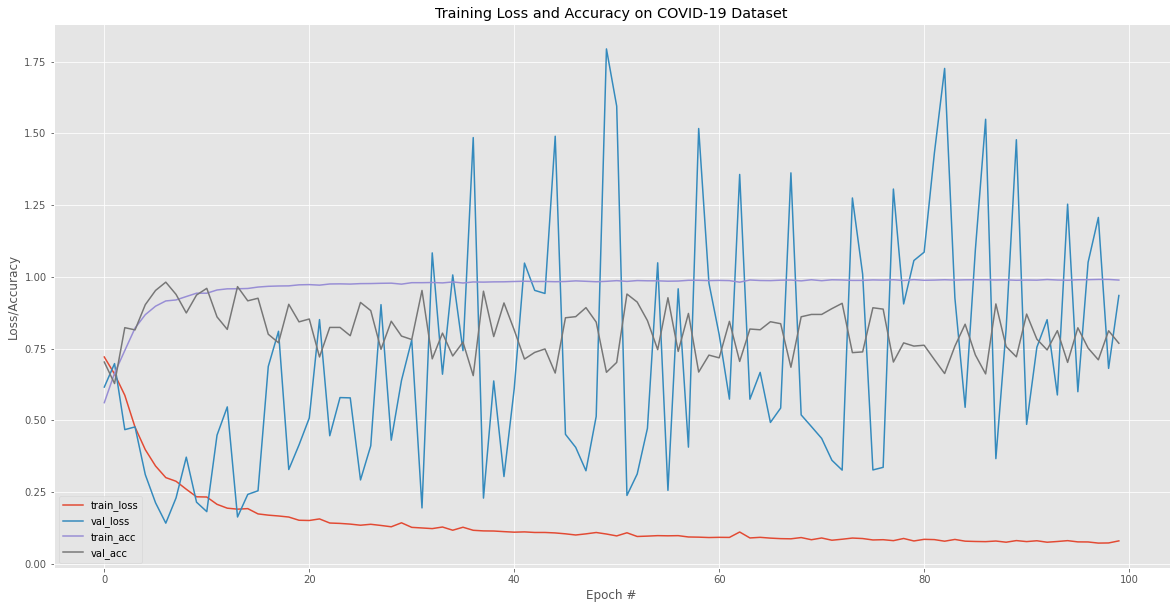

In [25]:
N = EPOCHS
plt.style.use("ggplot")
#plt.figure(figsize=(20,10))
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N),history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [31]:
model=load_model('/notebooks/model_src/model_0.994.hdf5')

In [32]:
model.evaluate([test_images1,test_images2],test_labels)

180/180 [==============================] - 2s 8ms/step - loss: 0.0630 - accuracy: 0.9956


[0.06303887814283371, 0.9956499338150024]